In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import DataParallel

from torchviz import make_dot

from dataset import mnist
from util import (
    print_model_parameters,
    gp_sampler,
    get_torch_size_string,
    plot_1xN_torch_traj_tensor,
    periodic_step,
    plot_ddpm_1d_result,
    get_resampling_steps,
)

from dataset import get_1d_training_data, mnist

from diffusion import (
    get_ddpm_constants,
    plot_ddpm_constants,
    DiffusionUNet,
    forward_sample,
    eval_ddpm_1d,
)

np.set_printoptions(precision=3)
th.set_printoptions(precision=3)

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# ddpm constants setting

dc = get_ddpm_constants(
    schedule_name = 'cosine',
    T             = 1000,
    np_type       = np.float32,
)

In [3]:
# Unet model setting
device = 'cuda:0' 
model = DiffusionUNet(
    name                 = 'unet',
    dims                 = 1,
    n_in_channels        = 1,
    n_model_channels     = 64,
    n_emb_dim            = 256,
    n_enc_blocks         = 2, 
    n_dec_blocks         = 2, 
    n_groups             = 16,
    n_heads              = 4, 
    actv                 = nn.SiLU(),
    kernel_size          = 15,
    padding              = 7,
    use_resblock         = True,
    use_attention        = True,
    skip_connection      = True, 
    use_scale_shift_norm = True, 
    device               = device,
)


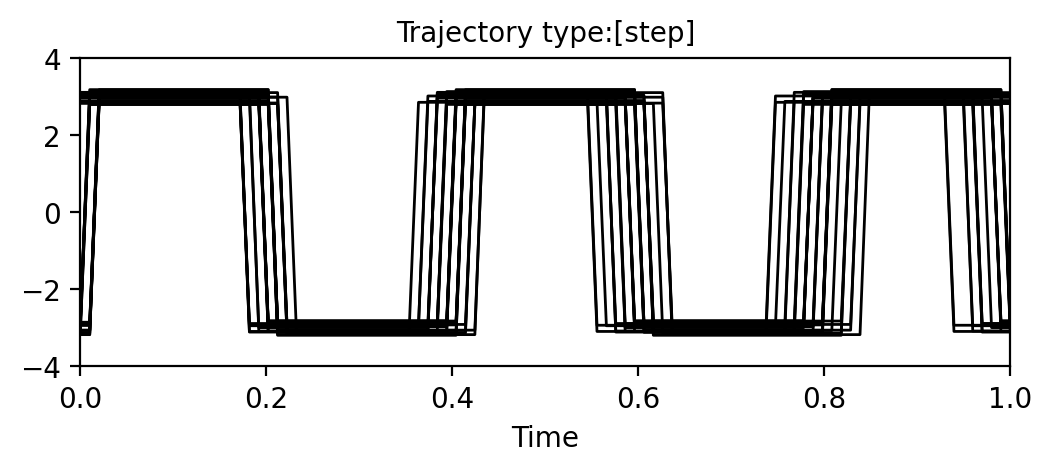

x_0:[30x1x100]


In [5]:
times,x_0 = get_1d_training_data(
    traj_type = 'step', # gp / step / step2
    n_traj    = 30,
    L         = 100,
    device    = device,
    seed      = 1010,
    plot_data = True,
    verbose   = True
    )

it:[      0][0.0]% loss:[4.7976]


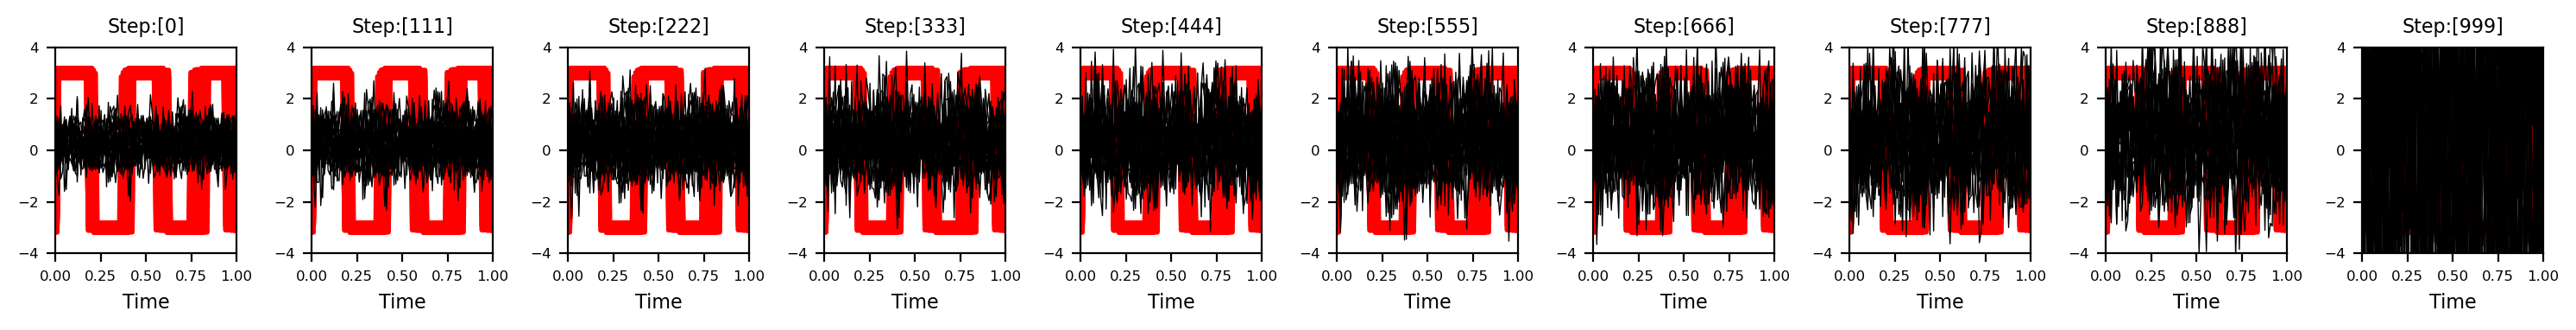

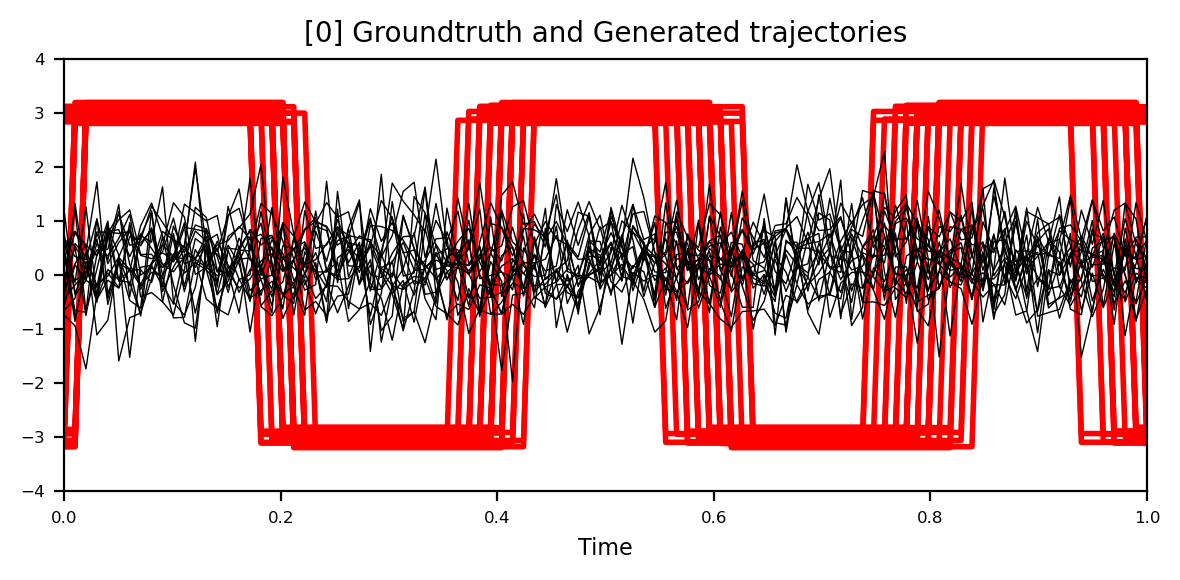

it:[   1000][5.0]% loss:[0.1623]
it:[   2000][10.0]% loss:[0.1122]


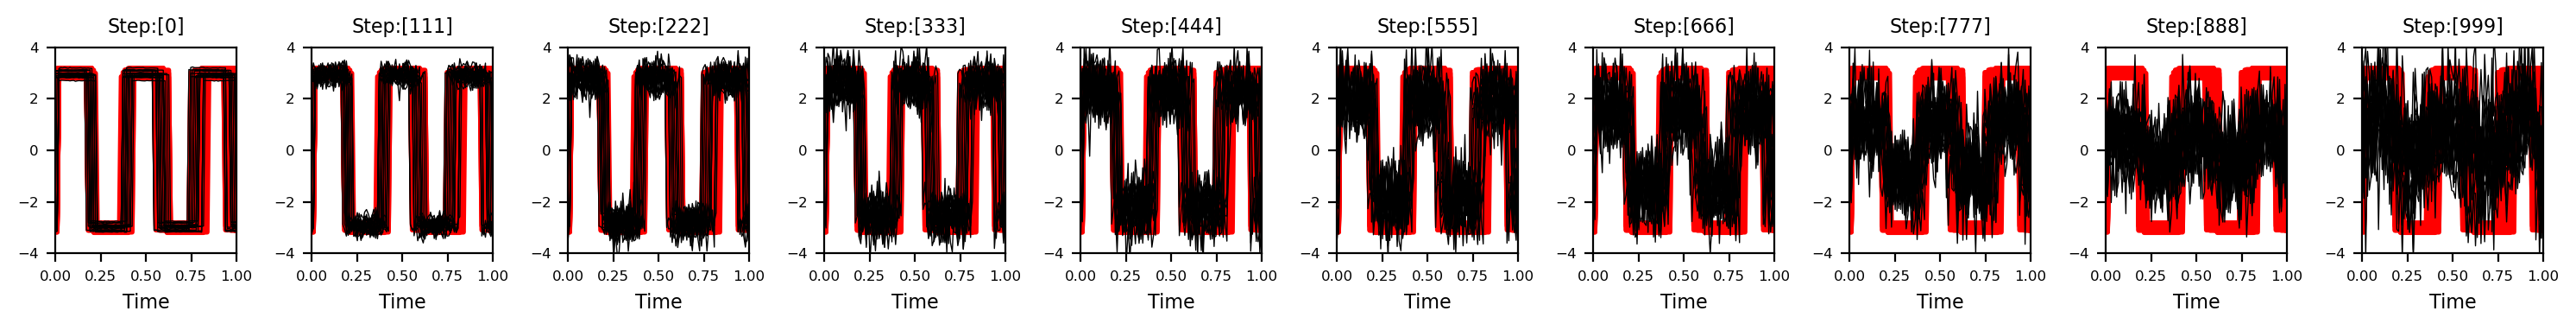

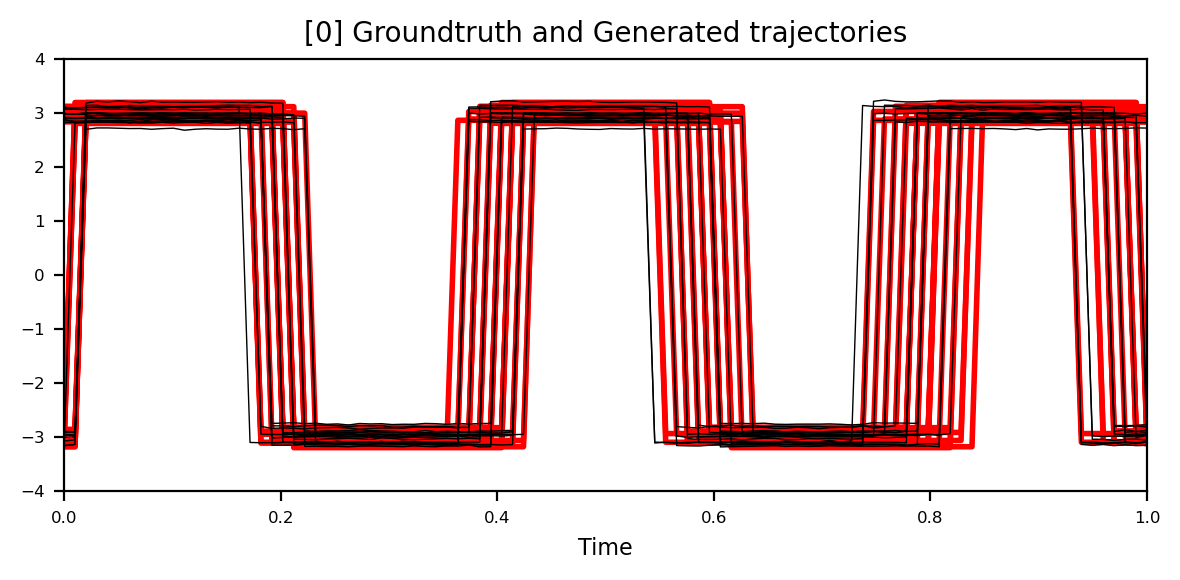

it:[   3000][15.0]% loss:[0.1187]
it:[   4000][20.0]% loss:[0.1107]


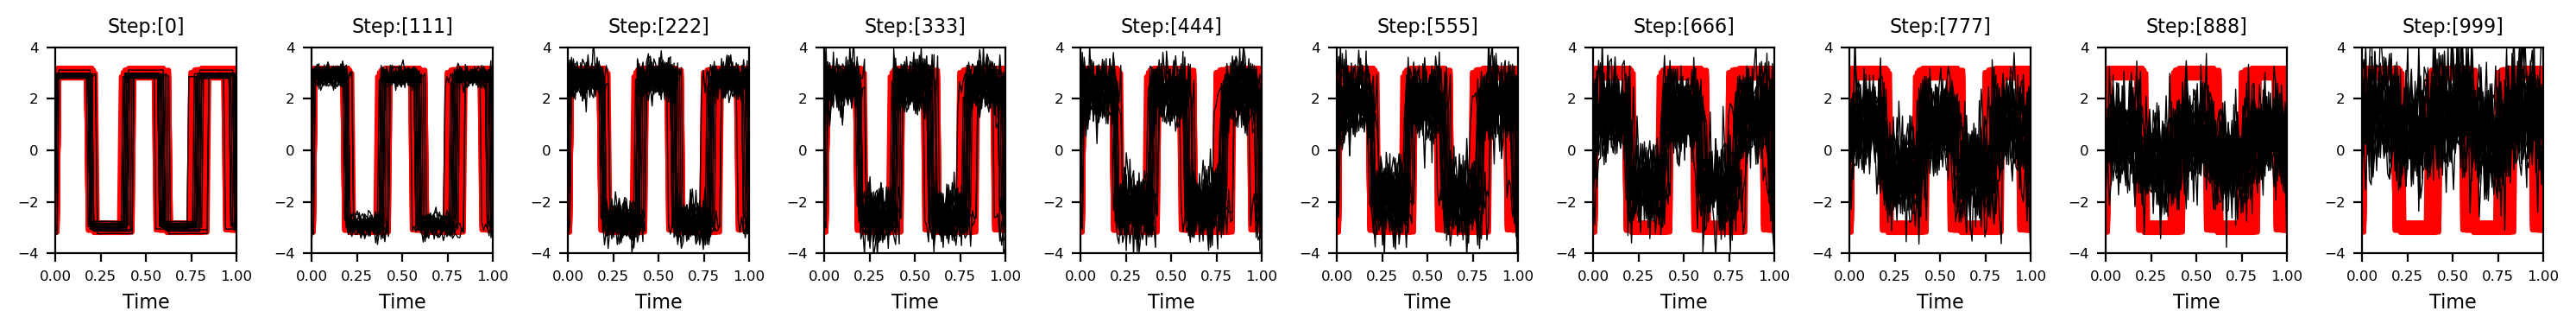

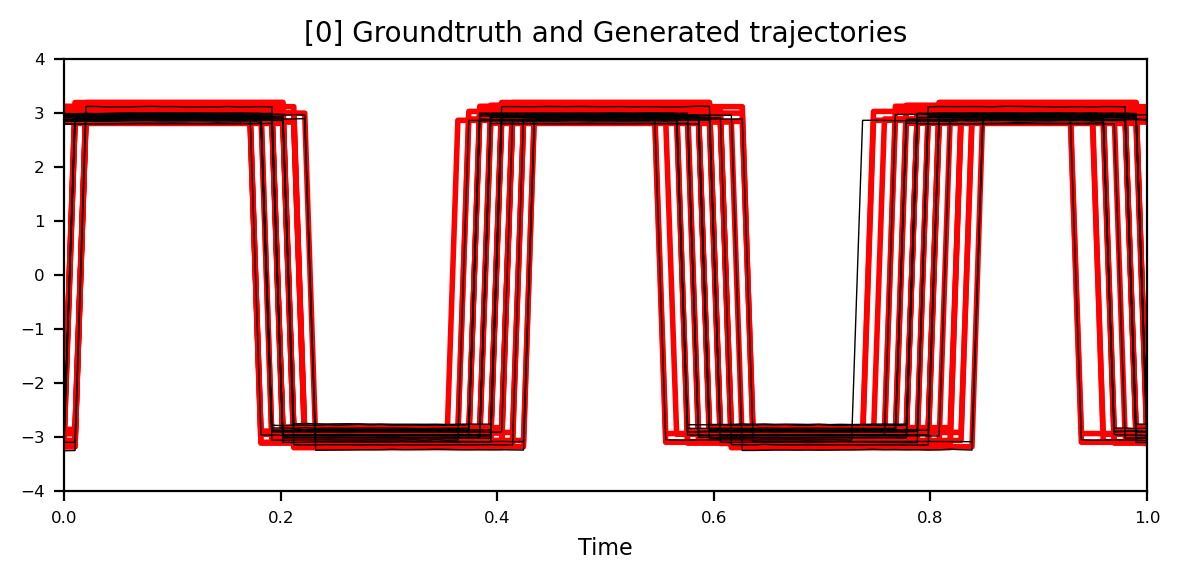

it:[   5000][25.0]% loss:[0.1030]
it:[   6000][30.0]% loss:[0.0933]


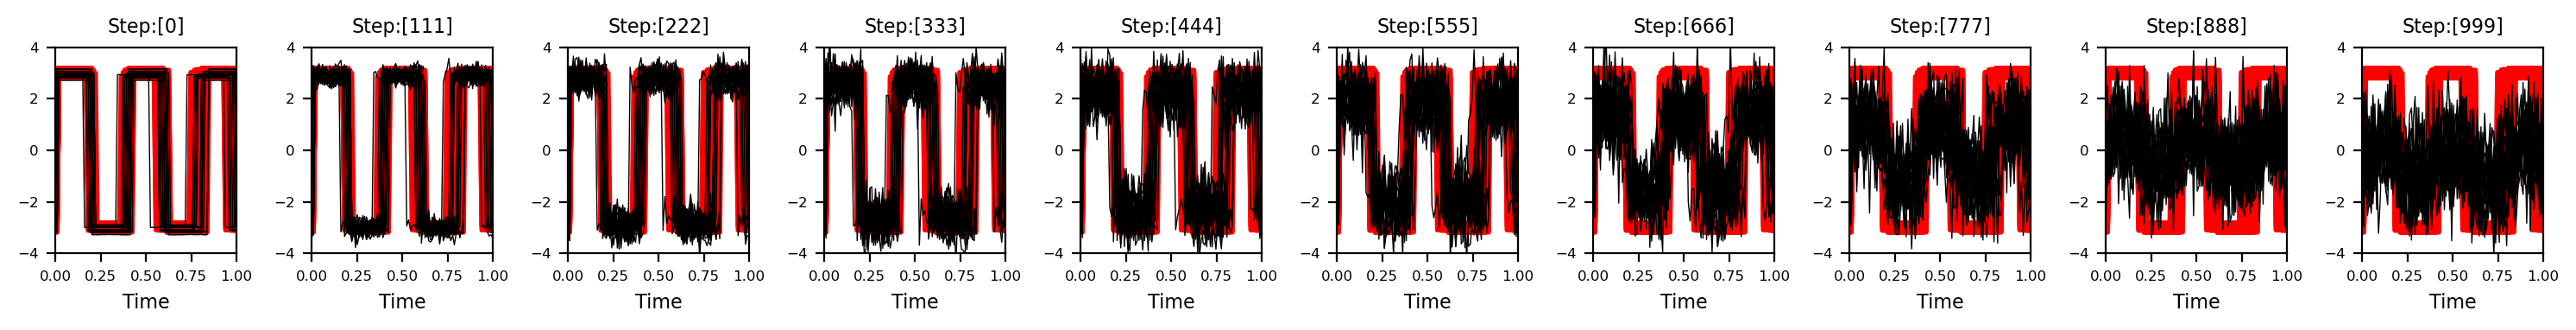

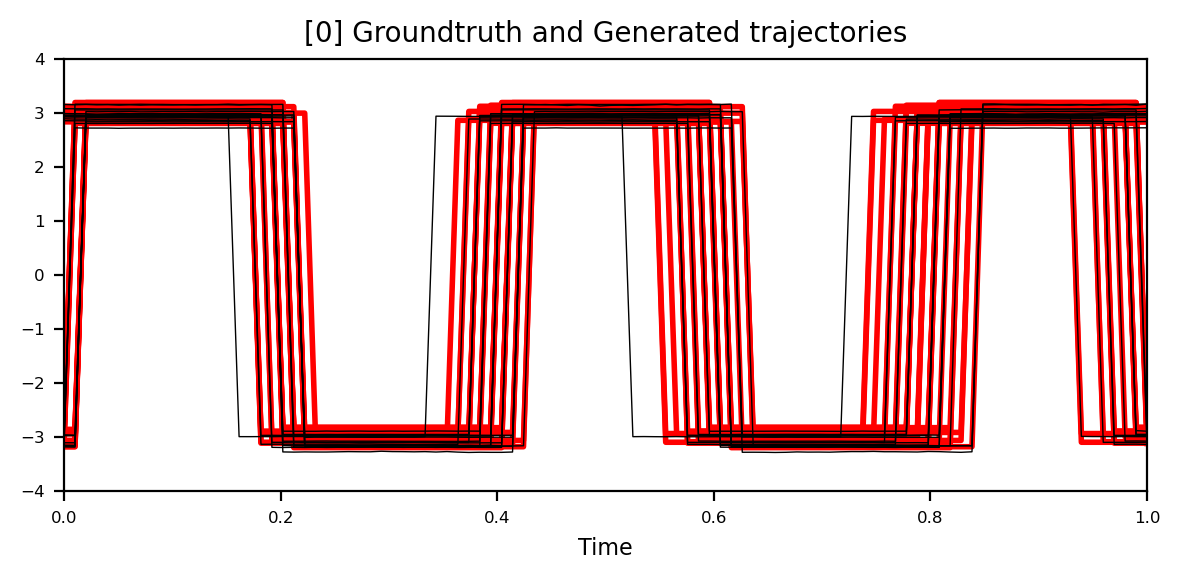

it:[   7000][35.0]% loss:[0.0885]
it:[   8000][40.0]% loss:[0.0768]


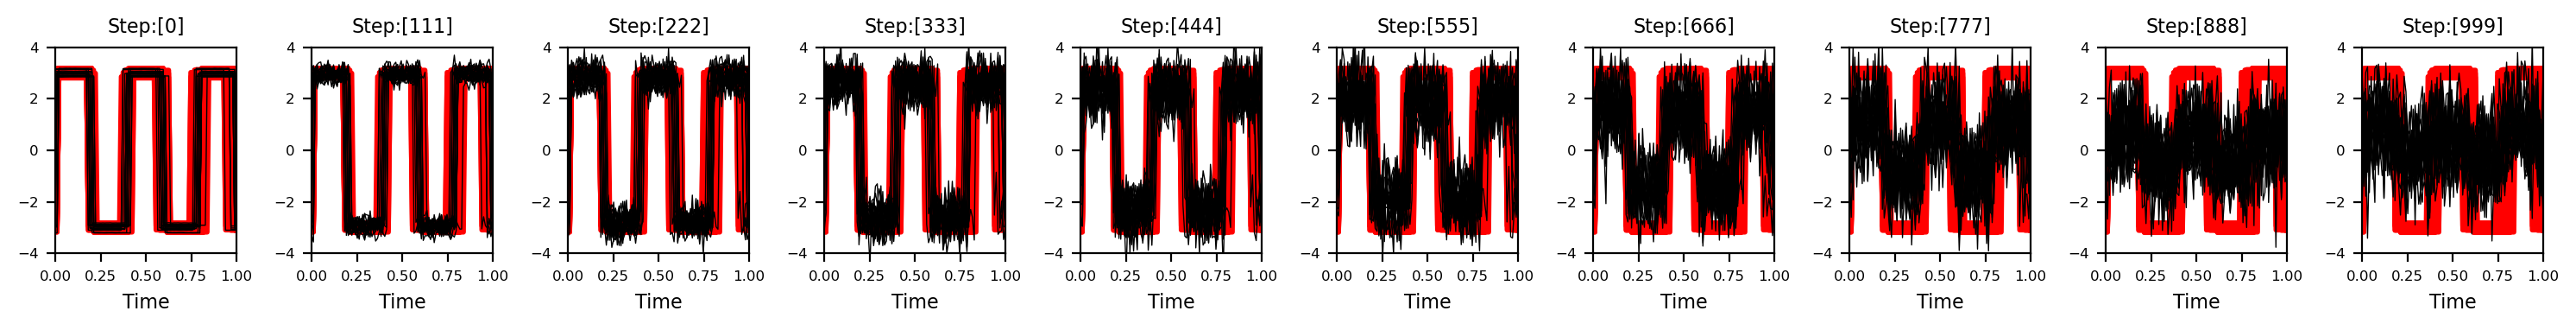

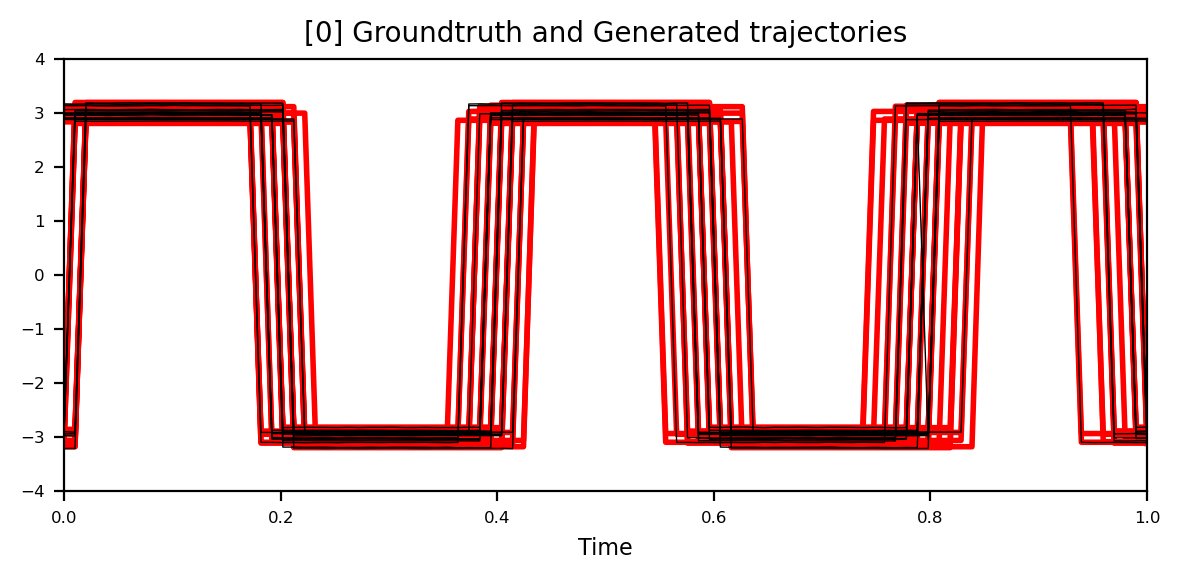

it:[   9000][45.0]% loss:[0.0905]
it:[  10000][50.0]% loss:[0.0761]


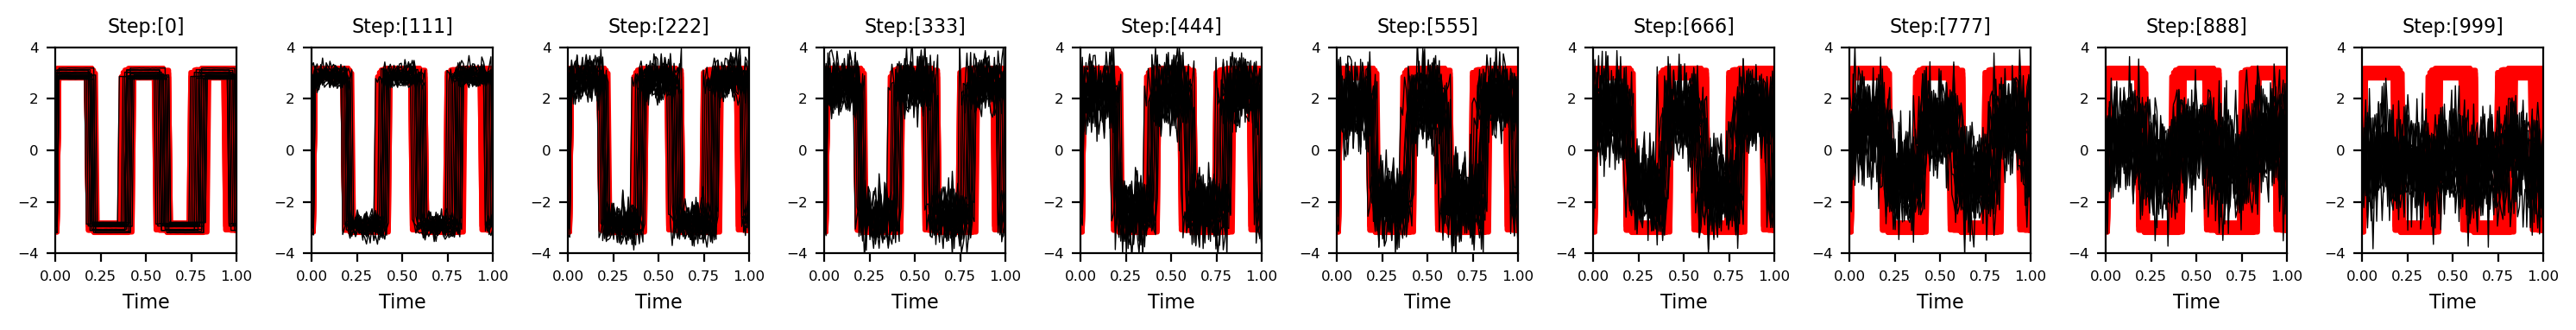

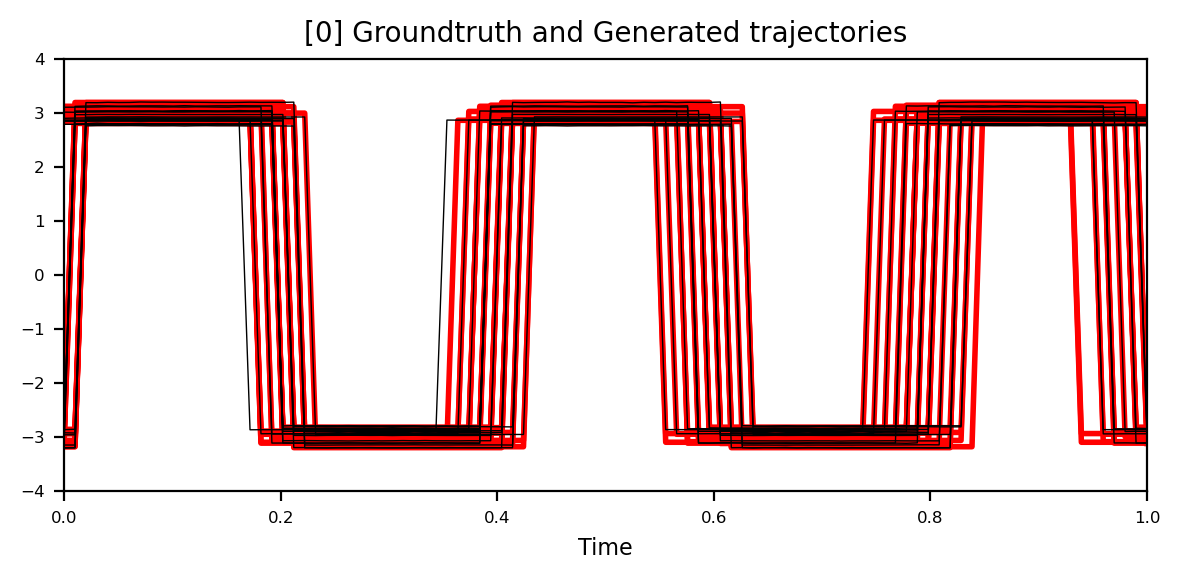

it:[  11000][55.0]% loss:[0.0826]
it:[  12000][60.0]% loss:[0.0748]


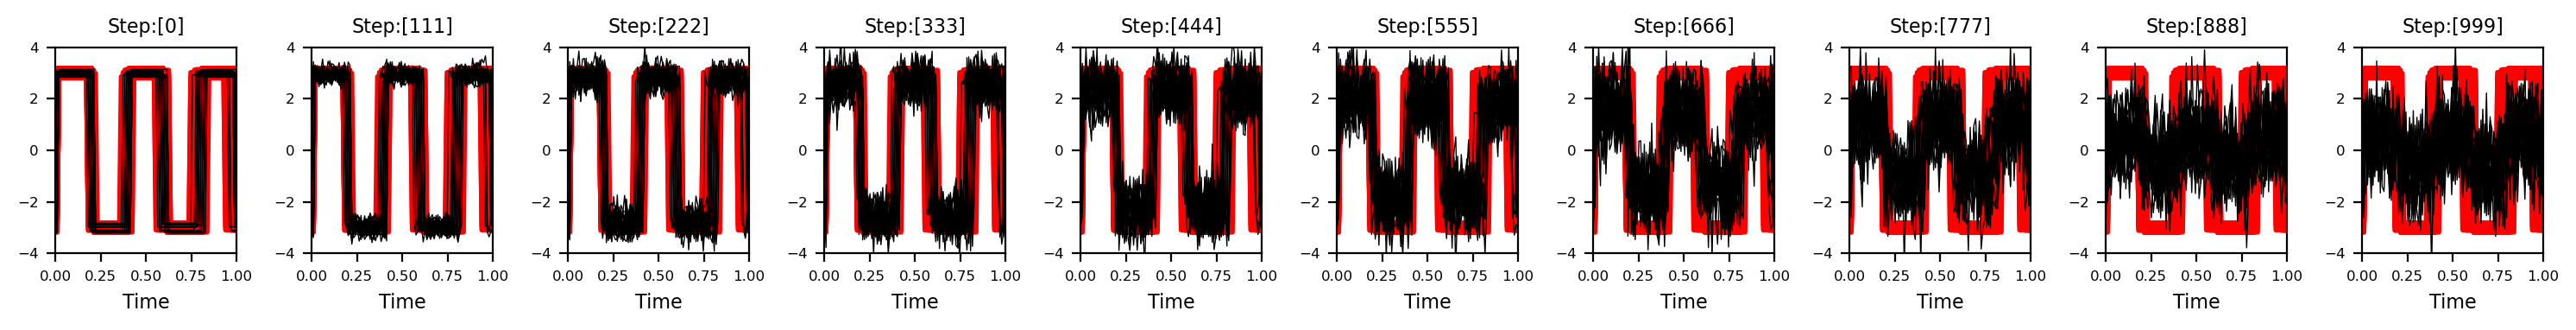

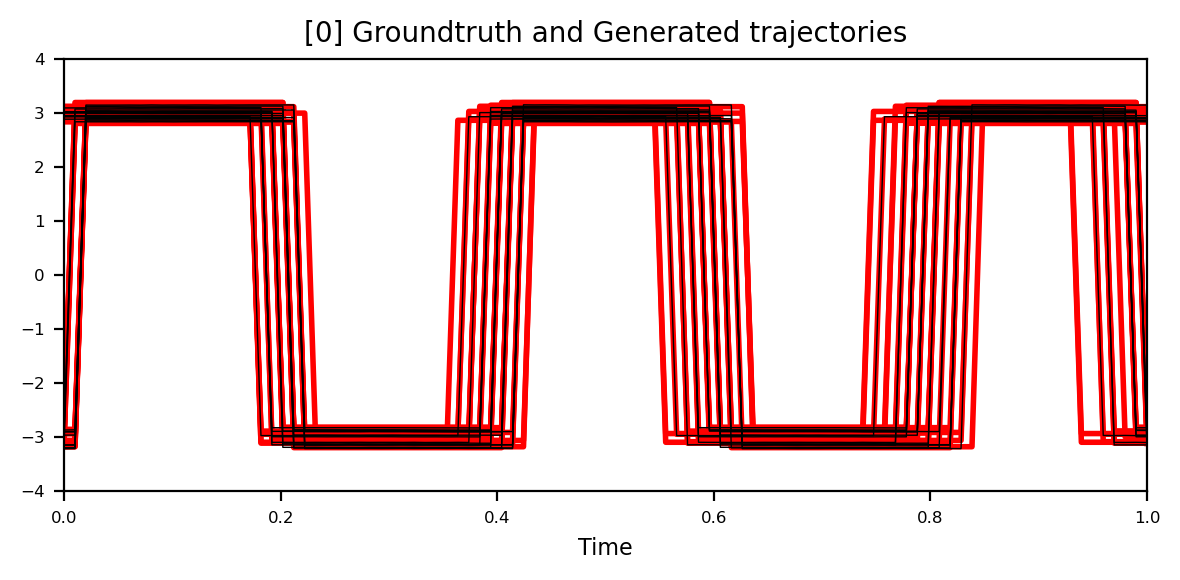

it:[  13000][65.0]% loss:[0.0695]
it:[  14000][70.0]% loss:[0.0622]


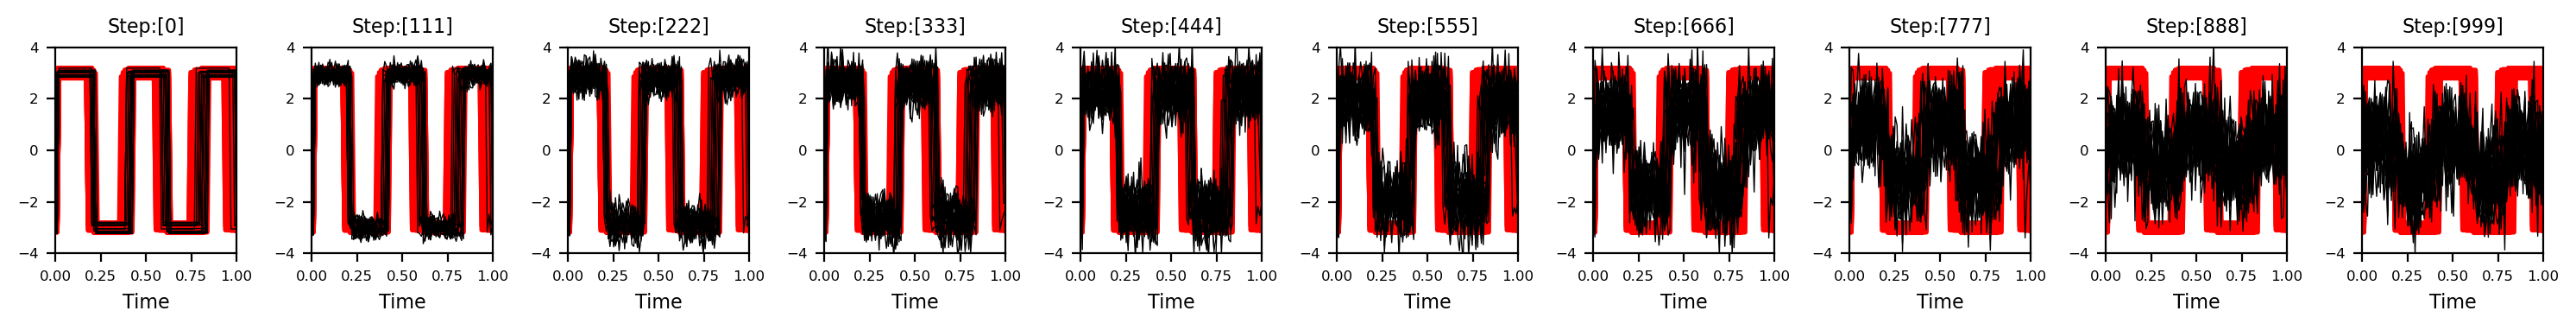

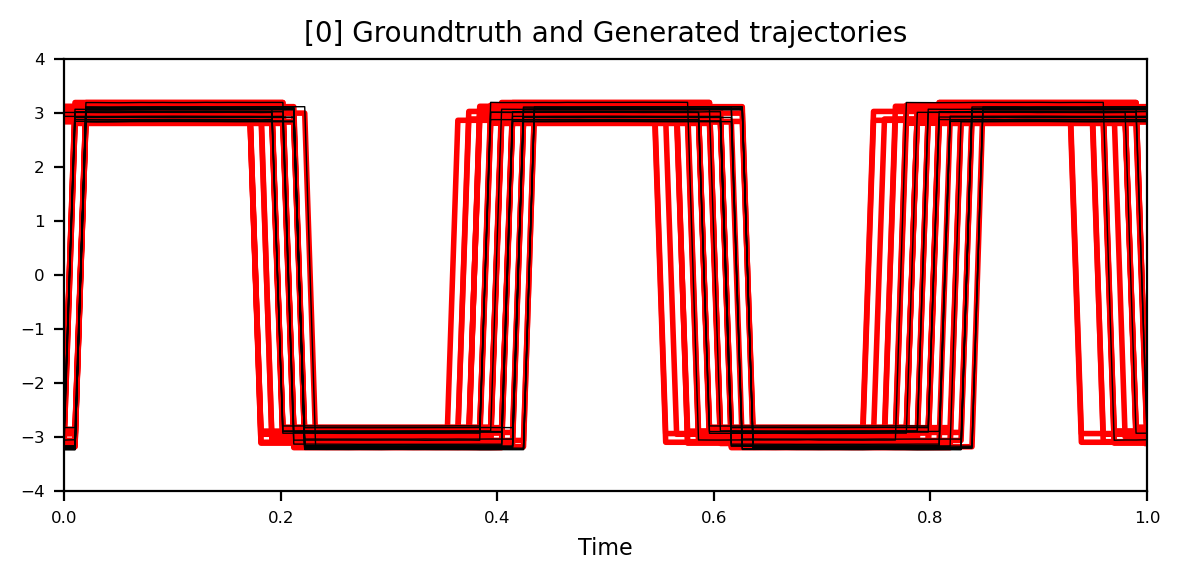

it:[  15000][75.0]% loss:[0.0706]
it:[  16000][80.0]% loss:[0.0636]


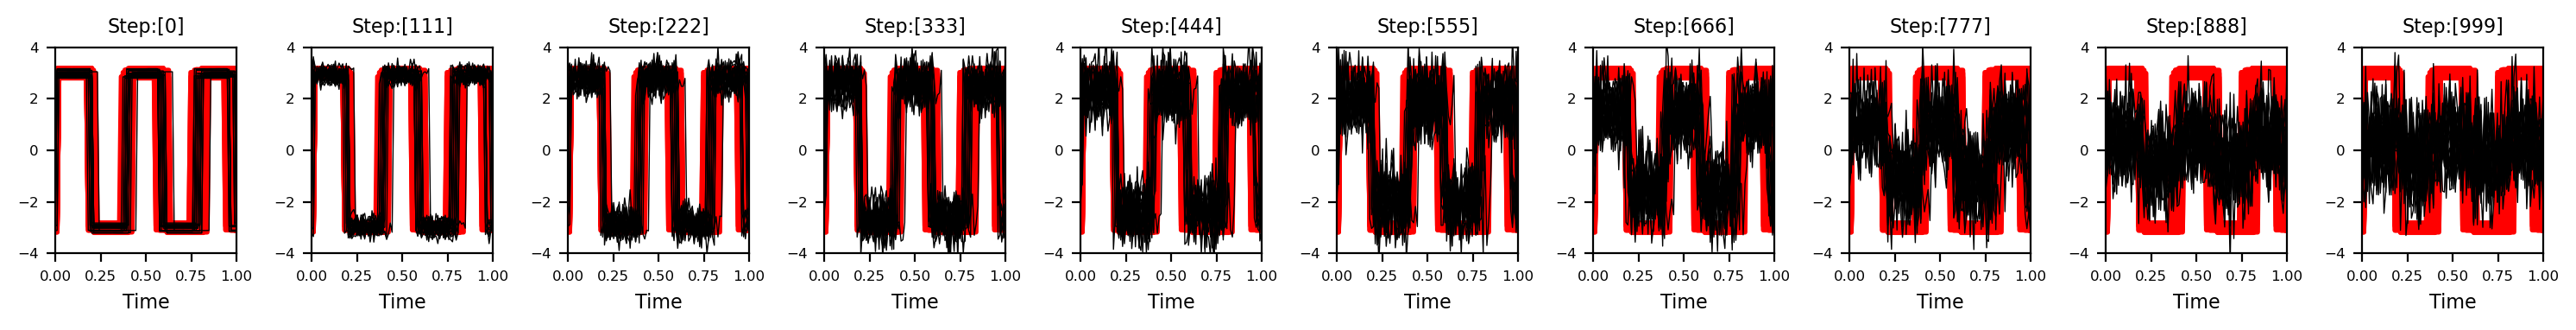

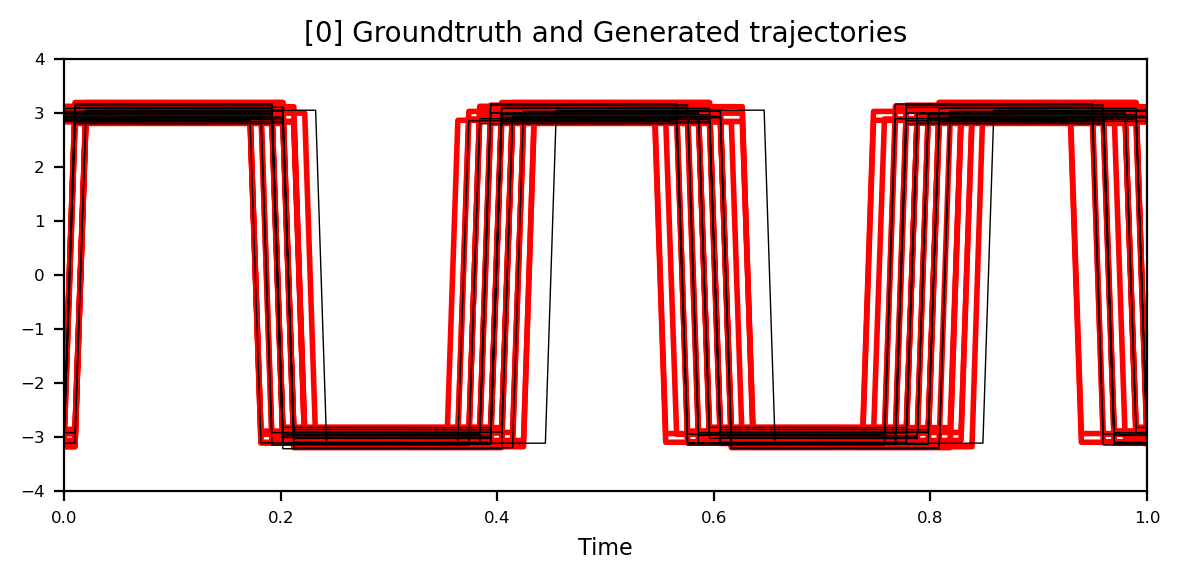

it:[  17000][85.0]% loss:[0.0618]
it:[  18000][90.0]% loss:[0.0700]


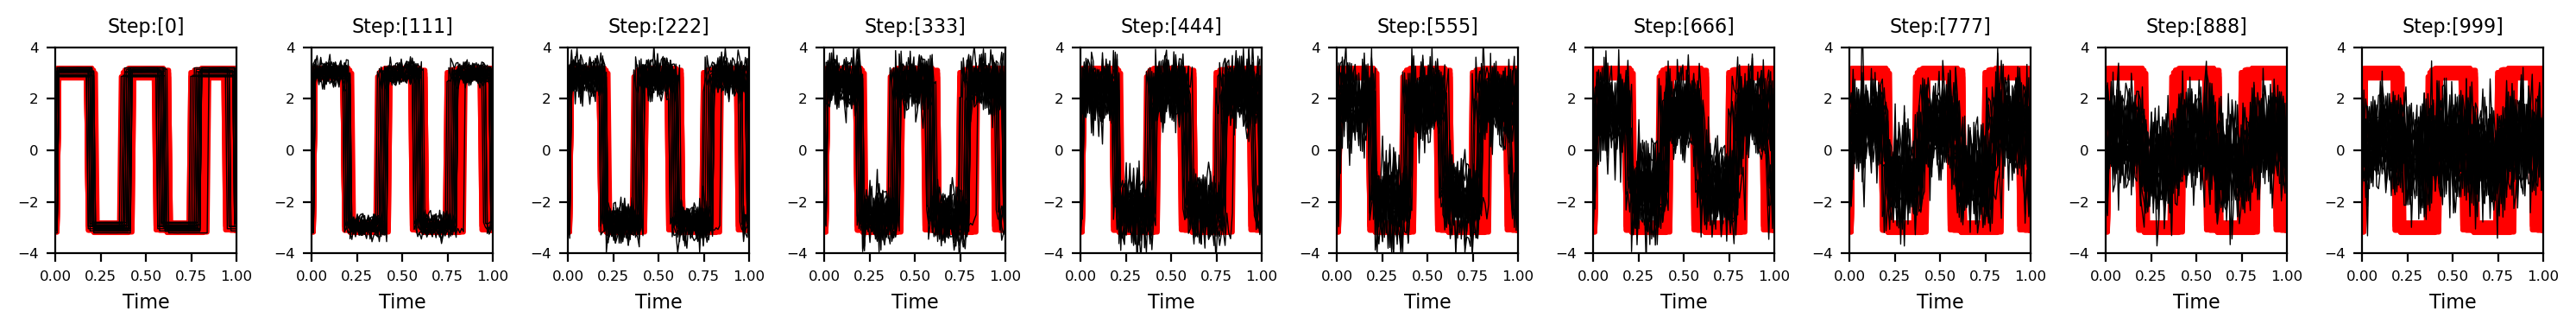

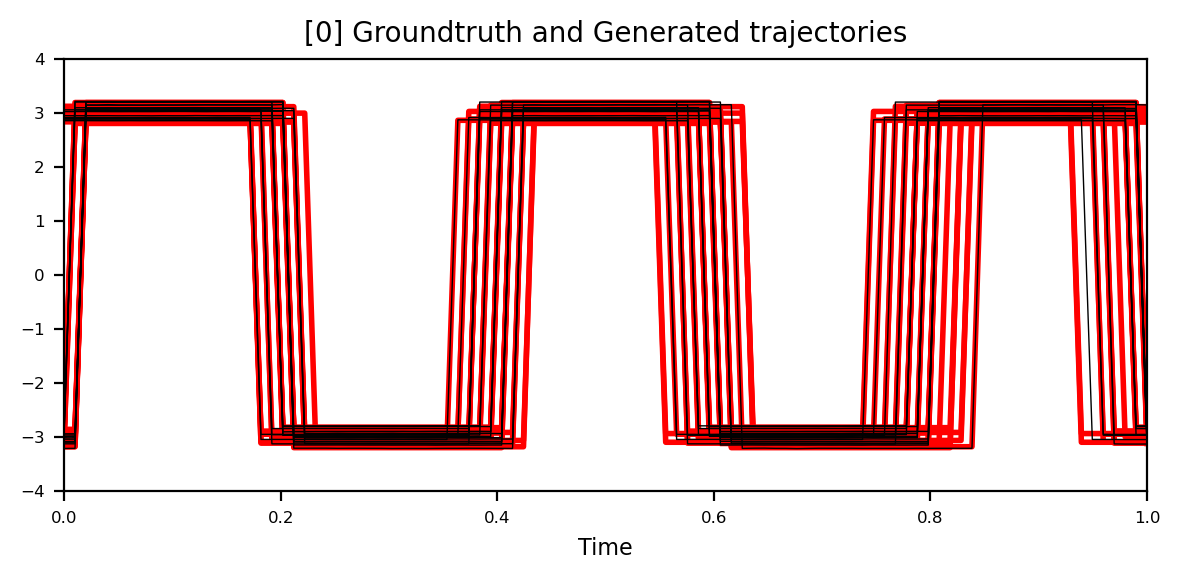

it:[  19000][95.0]% loss:[0.0635]
it:[  19999][100.0]% loss:[0.0610]


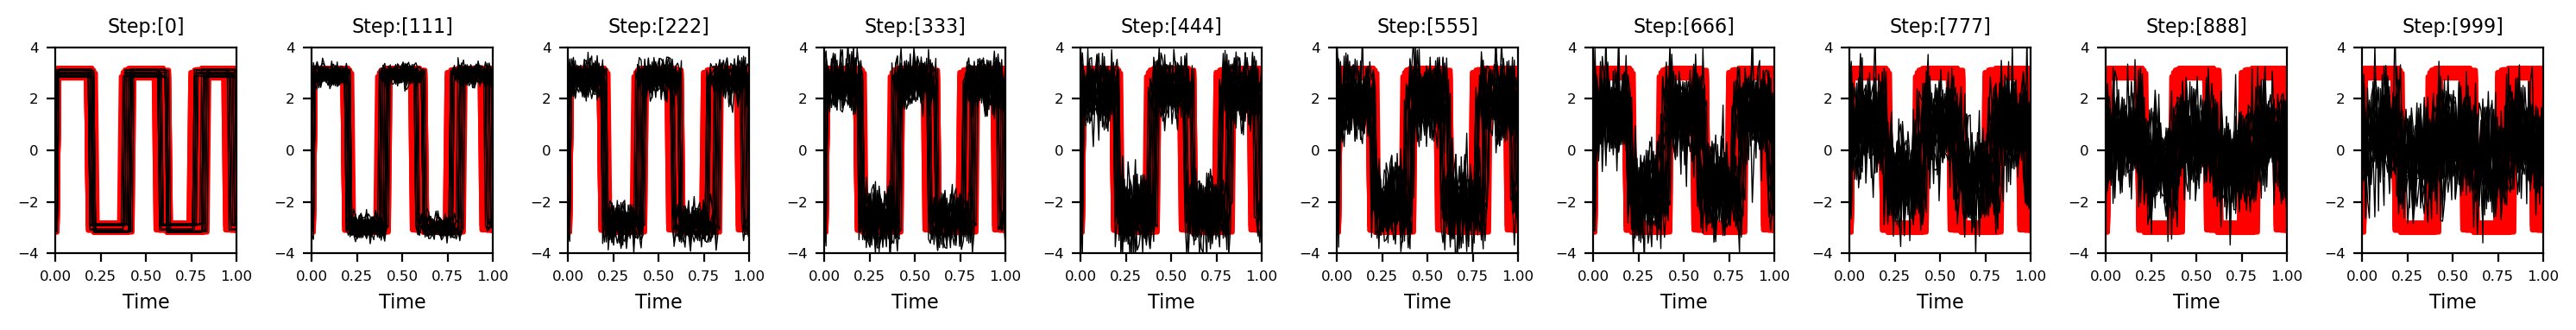

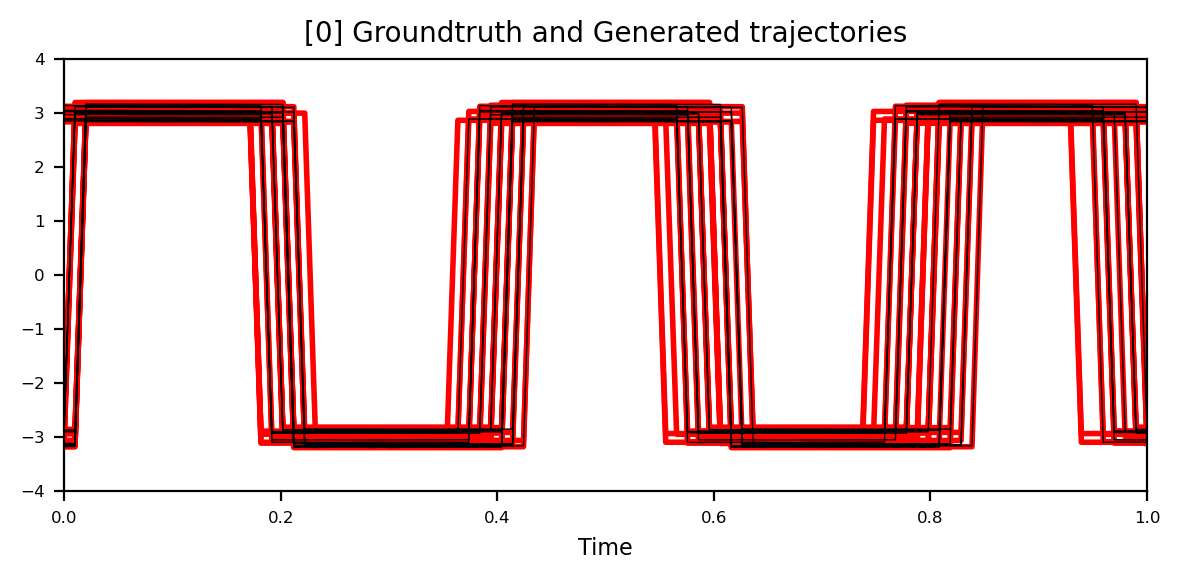

In [6]:
# Configuration
max_iter    = int(2e4)
batch_size  = 128
print_every = 1e3
eval_every  = 2e3

# Loop
model.train()
optm = th.optim.AdamW(params=model.parameters(),lr=1e-4,weight_decay=0.0)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm,gamma=0.99998)
for it in range(max_iter):
    
    # Zero gradient
    optm.zero_grad()
    
    # Get batch
    idx = np.random.choice(x_0.shape[0],batch_size)
    x_0_batch = x_0[idx,:,:] # [B x C x L]
    
    # Sample time steps
    step_batch = th.randint(0, dc['T'],(batch_size,),device=device).long() # [B]
    
    # Forward diffusion sampling
    x_t_batch,noise = forward_sample(x_0_batch,step_batch,dc) # [B x C x L]

    # Noise prediction
    noise_pred,_ = model(x_t_batch,step_batch) # [B x C x L]
    
    # Compute error
    loss = F.mse_loss(noise,noise_pred)+F.smooth_l1_loss(noise,noise_pred,beta=0.01)
    
    # Update
    loss.backward()
    optm.step()
    schd.step()
    
    # Print
    if (it%print_every) == 0 or it == (max_iter-1):
        print ("it:[%7d][%.1f]%% loss:[%.4f]"%(it,100*it/max_iter,loss.item()))
    
    # Evaluate
    if (it%eval_every) == 0 or it == (max_iter-1):
        n_sample = 20
        step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
        x_t_list = eval_ddpm_1d(model,dc,n_sample,x_0,step_list_to_append,device)
        plot_ddpm_1d_result(
            times=times,x_data=x_0,step_list=step_list_to_append,x_t_list=x_t_list,
            plot_one_sample=False,lw_gt=2,lw_sample=1/2,lc_gt='r',lc_sample='k',
            ylim=(-4,+4))

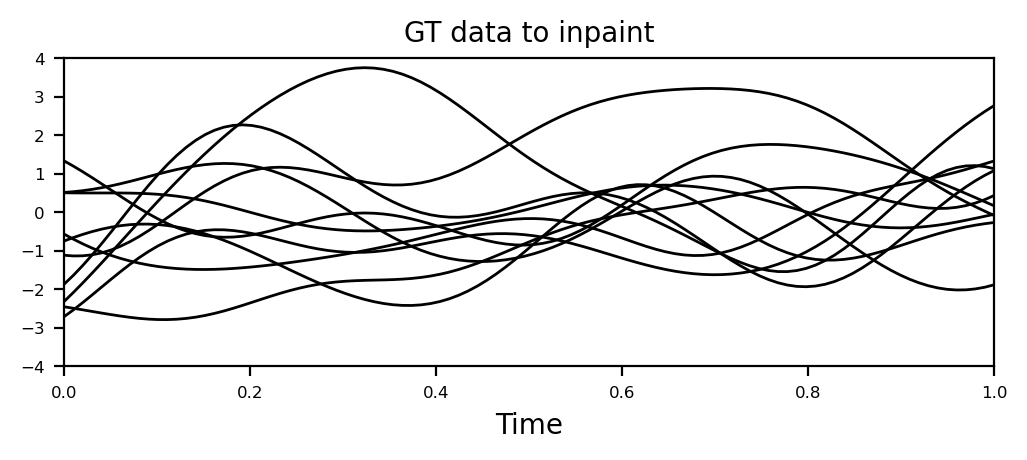

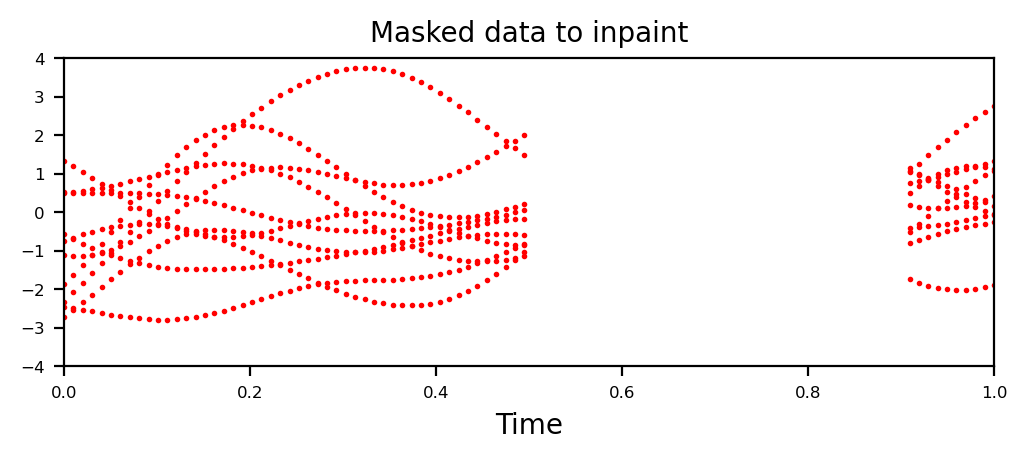

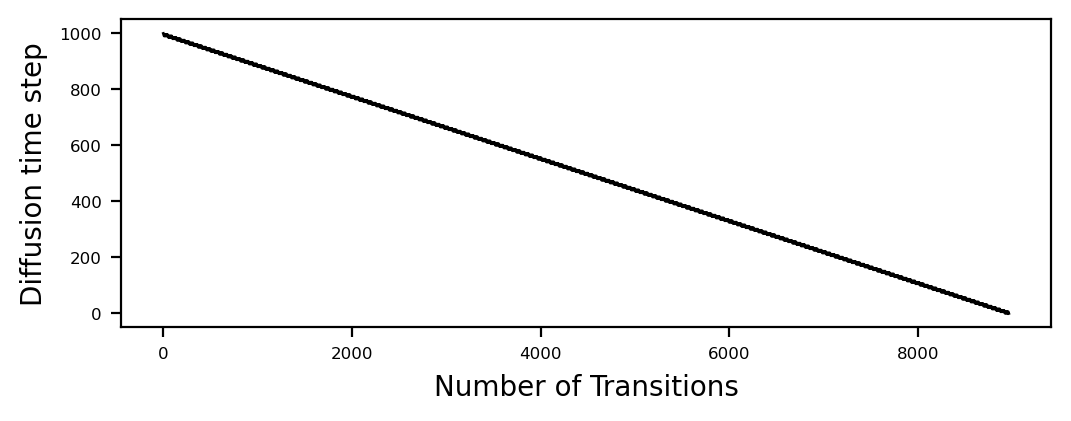

In [7]:
# Get 'x_gt' to inpaint
_,x_gt = get_1d_training_data(
    traj_type = 'gp', # gp / step / step2
    n_traj    = 10,
    L         = 100,
    device    = device,
    seed      = 815,
    plot_data = False,
    verbose   = False
    ) # original data to impaint [N x 1 x 100]
masking = th.ones_like(x_gt) # [N x 1 x 100]
masking[:,:,50:90] = 0
idx_valid = (masking.cpu().numpy()==1)
x_gt_masked = masking*x_gt # [N x 1 x 100]

# Plot `x_gt` and 'x_gt_masked'
n_gt = x_gt.shape[0]
plt.figure(figsize=(6,2))
for i_idx in range(n_gt): 
    plt.plot(times.reshape(-1),x_gt[i_idx,0,:].cpu().numpy(),ls='-',color='k',lw=1)
plt.xlim([0.0,1.0]); plt.ylim([-4,+4])
plt.xlabel('Time',fontsize=10)
plt.title('GT data to inpaint',fontsize=10); plt.show()
n_gt = x_gt.shape[0]
plt.figure(figsize=(6,2))
for i_idx in range(n_gt): 
    plt.plot(
        times[idx_valid[i_idx,0,:],0],
        x_gt_masked[i_idx,0,idx_valid[i_idx,0,:]].cpu().numpy(),
        'o',color='r',lw=1,ms=1)
plt.xlim([0.0,1.0]); plt.ylim([-4,+4])
plt.xlabel('Time',fontsize=10)
plt.title('Masked data to inpaint',fontsize=10); plt.show()

# Get resampling time steps
resampling_steps = get_resampling_steps(
    t_T = 1000,
    j   = 5, 
    r   = 5,
    plot_steps = True,
    figsize=(6,2)
    )


In [8]:
n_inpaint,C,L = x_gt_masked.shape
model.eval()
timestep_prev = -1
for (idx,t) in enumerate(resampling_steps): # for all repaint steps

    if idx == 0: # the initial inpainting step
        x_dummy    = th.zeros(n_inpaint,C,L,device=device)
        step_dummy = th.zeros(n_inpaint).type(th.long).to(device)
        _,x_t = forward_sample(x_dummy,step_dummy,dc) # [n_inpaint x C x L]
    
    elif t == 0: # the final inpainting step
        step = th.full(
            size       = (n_inpaint,),
            fill_value = t,
            device     = device,
            dtype      = th.long) # [n_inpaint]
        with th.no_grad():
            eps_model,_ = model(x_t,step) # [n_inpaint x C x L]
        betas_t = th.gather(
            input = th.from_numpy(dc['betas']).to(device), # [T]
            dim   = -1,
            index = step
        ).reshape((-1,1,1)) # [n_inpaint x 1 x 1]
        sqrt_one_minus_alphas_bar_t = th.gather(
            input = th.from_numpy(dc['sqrt_one_minus_alphas_bar']).to(device), # [T]
            dim   = -1,
            index = step
        ).reshape((-1,1,1)) # [n_inpaint x 1 x 1]
        sqrt_recip_alphas_t = th.gather(
            input = th.from_numpy(dc['sqrt_recip_alphas']).to(device), # [T]
            dim   = -1,
            index = step
        ).reshape((-1,1,1)) # [n_inpaint x 1 x 1]
        # Compute (reverse) posterior mean
        x_t = sqrt_recip_alphas_t * (
            x_t - betas_t*eps_model/sqrt_one_minus_alphas_bar_t
            ) # [n_inpaint x C x L]
    
    elif t < t_prev: # reverse process
        # Jump diffusion of 'x_gt_masked'
        step = th.full(
            size       = (n_inpaint,),
            fill_value = t,
            device     = device,
            dtype      = th.long) # [n_inpaint]
        x_t_known,_ = forward_sample(x_gt_masked,step,dc) # [n_inpaint x C x L]
        # Reverse step
        with th.no_grad():
            eps_model,_ = model(x_t,step) # [n_inpaint x C x L]
        betas_t = th.gather(
            input = th.from_numpy(dc['betas']).to(device), # [T]
            dim   = -1,
            index = step
        ).reshape((-1,1,1)) # [n_inpaint x 1 x 1]
        sqrt_one_minus_alphas_bar_t = th.gather(
            input = th.from_numpy(dc['sqrt_one_minus_alphas_bar']).to(device), # [T]
            dim   = -1,
            index = step
        ).reshape((-1,1,1)) # [n_inpaint x 1 x 1]
        sqrt_recip_alphas_t = th.gather(
            input = th.from_numpy(dc['sqrt_recip_alphas']).to(device), # [T]
            dim   = -1,
            index = step
        ).reshape((-1,1,1)) # [n_inpaint x 1 x 1]
        posterior_variance_t = th.gather(
            input = th.from_numpy(dc['posterior_variance']).to(device), # [T]
            dim   = -1,
            index = step
        ).reshape((-1,1,1)) # [n_inpaint x 1 x 1]
        # Sample from (reverse) posterior 
        x_dummy    = th.zeros(n_inpaint,C,L,device=device)
        step_dummy = th.zeros(n_inpaint).type(th.long).to(device)
        _,eps_t = forward_sample(x_dummy,step_dummy,dc) # [n_inpaint x C x L]
        x_t_unknown = sqrt_recip_alphas_t * (
            x_t - betas_t*eps_model/sqrt_one_minus_alphas_bar_t
            ) + th.sqrt(posterior_variance_t)*eps_t # [n_inpaint x C x L]
        # Get x_t
        x_t = masking * x_t_known + (1-masking) * x_t_unknown # [n_inpaint x C x L]
    
    elif t > t_prev: # forward process
        step = th.full(
            size       = (n_inpaint,),
            fill_value = t,
            device     = device,
            dtype      = th.long) # [n_inpaint]
        betas_t = th.gather(
            input = th.from_numpy(dc['betas']).to(device), # [T]
            dim   = -1,
            index = step
        ).reshape((-1,1,1)) # [n_inpaint x 1 x 1]
        x_dummy    = th.zeros(n_inpaint,C,L,device=device)
        step_dummy = th.zeros(n_inpaint).type(th.long).to(device)
        _,eps_t = forward_sample(x_dummy,step_dummy,dc) # [n_inpaint x C x L]
        # Single forward step
        x_t = th.sqrt(1-betas_t)*x_t + th.sqrt(betas_t)*eps_t # [n_inpaint x C x L]
        
    # Backup previous step
    t_prev = t
x_inpaint = x_t
print ("Done.")

Done.


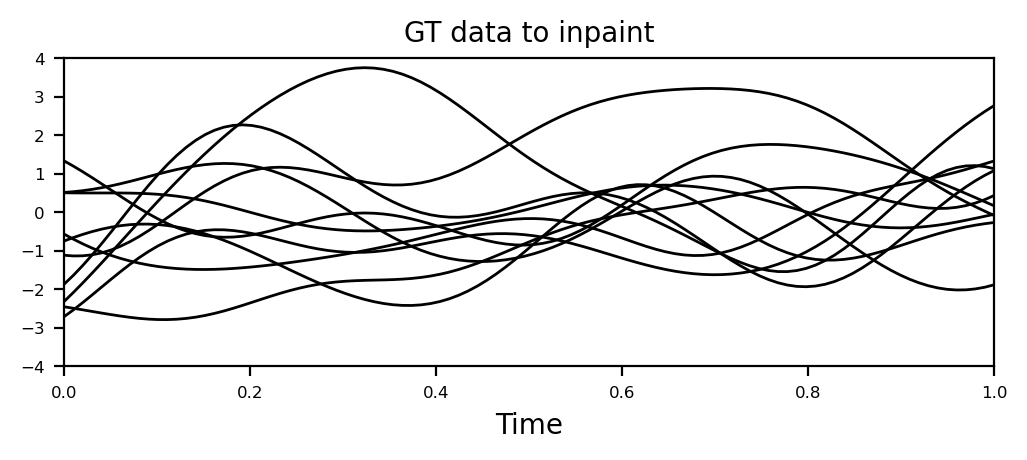

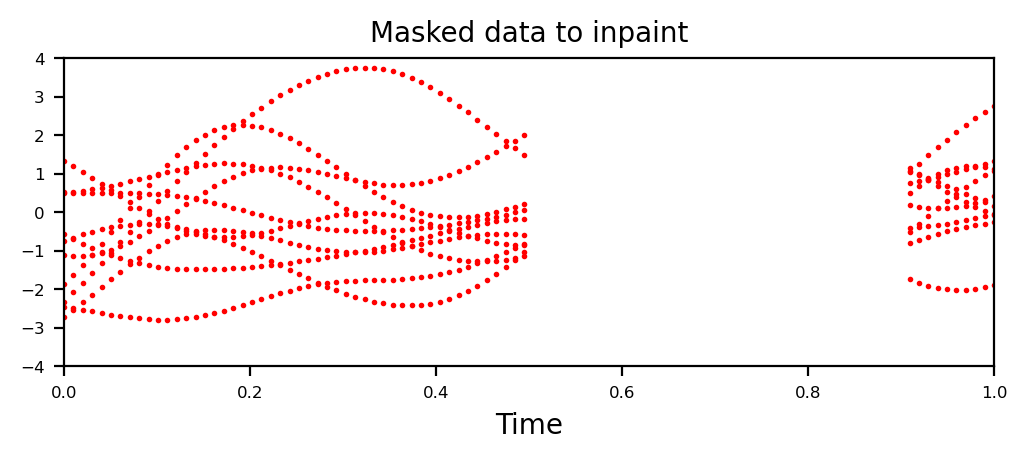

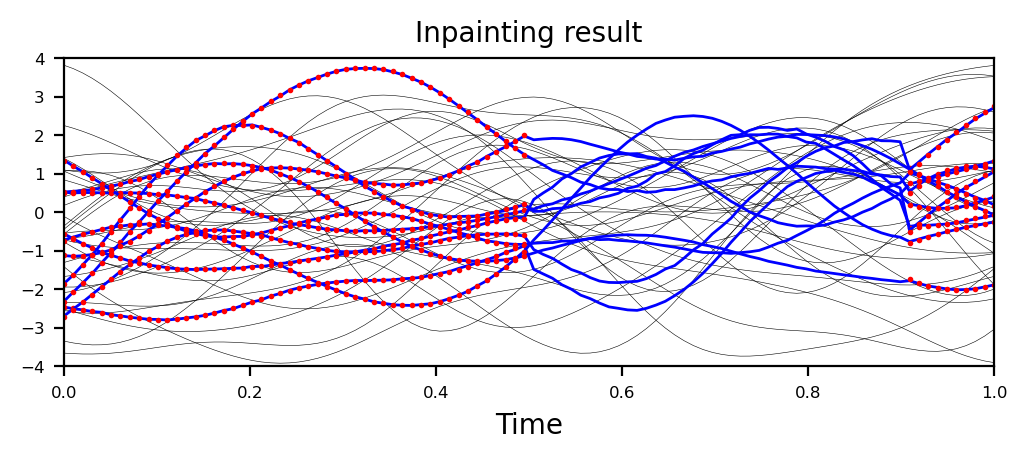

In [9]:
# Plot inpainting results
n_gt = x_gt.shape[0]
plt.figure(figsize=(6,2))
for i_idx in range(n_gt): 
    plt.plot(times.reshape(-1),x_gt[i_idx,0,:].cpu().numpy(),ls='-',color='k',lw=1)
plt.xlim([0.0,1.0]); plt.ylim([-4,+4])
plt.xlabel('Time',fontsize=10)
plt.title('GT data to inpaint',fontsize=10); plt.show()
n_gt = x_gt.shape[0]
plt.figure(figsize=(6,2))
for i_idx in range(n_gt): 
    plt.plot(
        times[idx_valid[i_idx,0,:],0],
        x_gt_masked[i_idx,0,idx_valid[i_idx,0,:]].cpu().numpy(),
        'o',color='r',lw=1,ms=1)
plt.xlim([0.0,1.0]); plt.ylim([-4,+4])
plt.xlabel('Time',fontsize=10)
plt.title('Masked data to inpaint',fontsize=10); plt.show()

plt.figure(figsize=(6,2))
for i_idx in range(x_0.shape[0]):
    plt.plot(times.reshape(-1),x_0[i_idx,0,:].cpu().numpy(),ls='-',color='k',lw=1/5)
for i_idx in range(n_gt):
    plt.plot(times.reshape(-1),x_inpaint[i_idx,0,:].cpu().numpy(),ls='-',color='b',lw=1)
    plt.plot(
        times[idx_valid[i_idx,0,:],0],
        x_gt_masked[i_idx,0,idx_valid[i_idx,0,:]].cpu().numpy(),
        'o',color='r',lw=1,ms=1)
plt.xlim([0.0,1.0]); plt.ylim([-4,+4])
plt.xlabel('Time',fontsize=10)
plt.title('Inpainting result',fontsize=10); plt.show()

---

In [24]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
# Instantiate U-net
device = 'cuda:0' # mps, cpu
model = DiffusionUNet(
    name                 = 'unet',
    dims                 = 1,
    n_in_channels        = 2,
    n_model_channels     = 128,
    n_emb_dim            = 128,
    n_enc_blocks         = 4, 
    n_dec_blocks         = 4, 
    n_groups             = 16,
    n_heads              = 4, 
    actv                 = nn.SiLU(),
    kernel_size          = 3,
    padding              = 1,
    use_resblock         = True,
    use_attention        = True,
    skip_connection      = True, 
    use_scale_shift_norm = True, 
    device               = device,
)

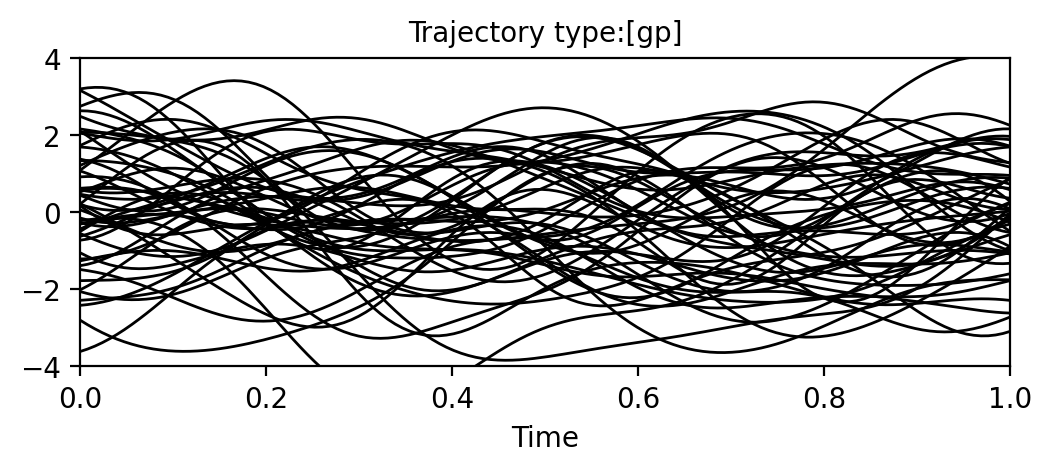

x_0:[50x1x128]


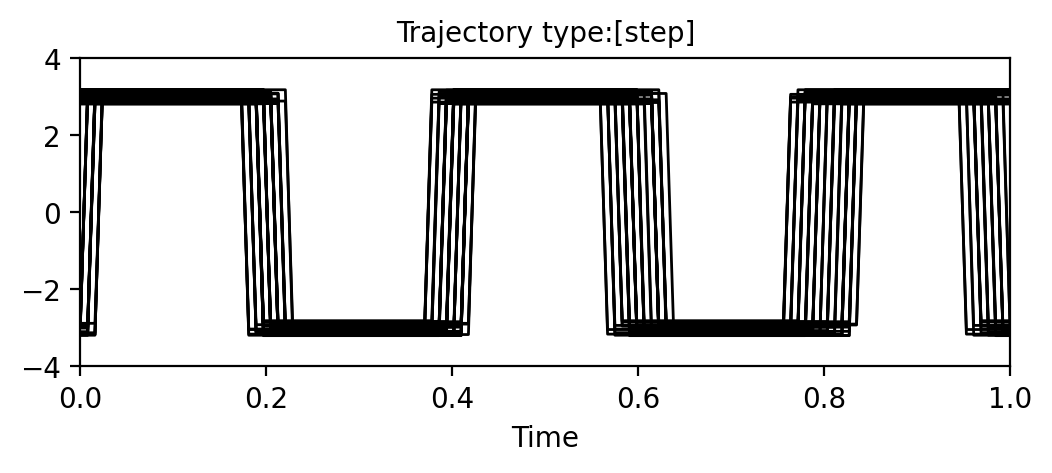

x_0:[50x1x128]


In [25]:
N,L,x_dim = 50,128,2
x_0_list = []
for d_idx in range(x_dim):
    if (d_idx%2) == 0:
        traj_type = 'gp'
    else:
        traj_type = 'step'
    times,x_0 = get_1d_training_data(
        traj_type = traj_type, # gp / step / step2
        n_traj    = N,
        L         = L,
        device    = device,
        seed      = d_idx,
        plot_data = True,
        verbose   = True
        ) # [N x 1 x 128]
    x_0_list.append(x_0)
    
x_0 = th.stack(x_0_list, axis=1).squeeze(axis=2)

tensor(28, device='cuda:0')

In [ ]:
# Configuration
max_iter    = 2e4
batch_size  = 128
print_every = 1e3
eval_every  = 5e3

# Loop
model.train()
optm = th.optim.AdamW(params=model.parameters(),lr=1e-4,weight_decay=0.0)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm,gamma=0.99998)

for it in range(int(max_iter)):
    # Zero gradient
    optm.zero_grad()
    # Get batch
    idx = np.random.choice(x_0.shape[0],batch_size)
    x_0_batch = x_0[idx,:,:] # [B x C x L]
    # Sample time steps
    step_batch = th.randint(0, dc['T'],(batch_size,),device=device).long() # [B]
    # Forward diffusion sampling
    x_t_batch,noise = forward_sample(x_0_batch,step_batch,dc) # [B x C x L]
    # Noise prediction
    noise_pred,_ = model(x_t_batch,step_batch) # [B x C x L]
    # Compute error
    loss = F.smooth_l1_loss(noise,noise_pred,beta=0.1)
    # Update
    loss.backward()
    optm.step()
    schd.step()
    # Print
    if (it%print_every) == 0 or it == (max_iter-1):
        print ("it:[%7d][%.1f]%% loss:[%.4f]"%(it,100*it/max_iter,loss.item()))
    # Evaluate
    if (it%eval_every) == 0 or it == (max_iter-1):
        n_sample = 20
        step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
        x_t_list = eval_ddpm_1d(model,dc,n_sample,x_0,step_list_to_append,device)
        plot_ddpm_1d_result(
            times=times,x_data=x_0,step_list=step_list_to_append,x_t_list=x_t_list,
            plot_ancestral_sampling=True,plot_one_sample=False,
            lw_gt=2,lw_sample=1/2,lc_gt=(0,1,0,0.3),lc_sample='k',
            ls_gt='-',ls_sample='--',ylim=(-4,+4),figsize=(5,3))
print ("Training done.")